In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [224]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [225]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


### **_EDA  (Exporatory data analysis)_**

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [227]:
print('Data shape before dropping columns with missing data : {}'.format(df.shape))

df.drop(['alley','miscfeature','fence','fireplacequ', 'poolqc'], axis = 1, inplace = True)

print('Data shape after dropping columns : {}'.format(df.shape))

Data shape before dropping columns with missing data : (1460, 81)
Data shape after dropping columns : (1460, 76)


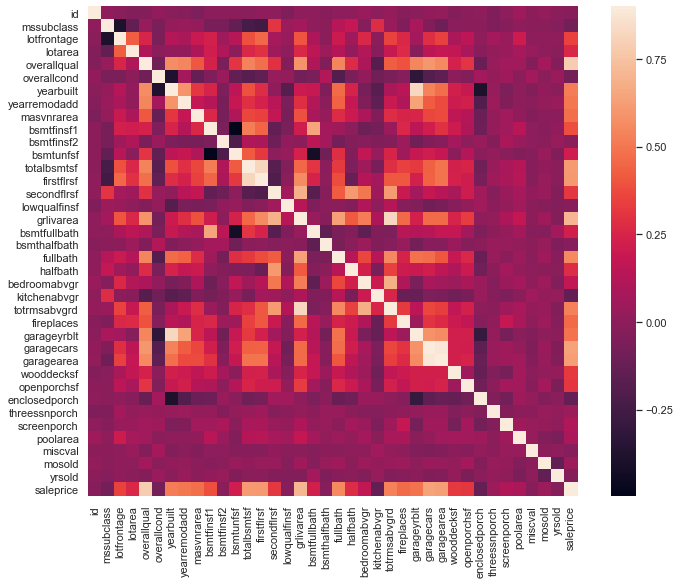

In [228]:
#Correlation map to see how features are correlated with SalePrice
corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

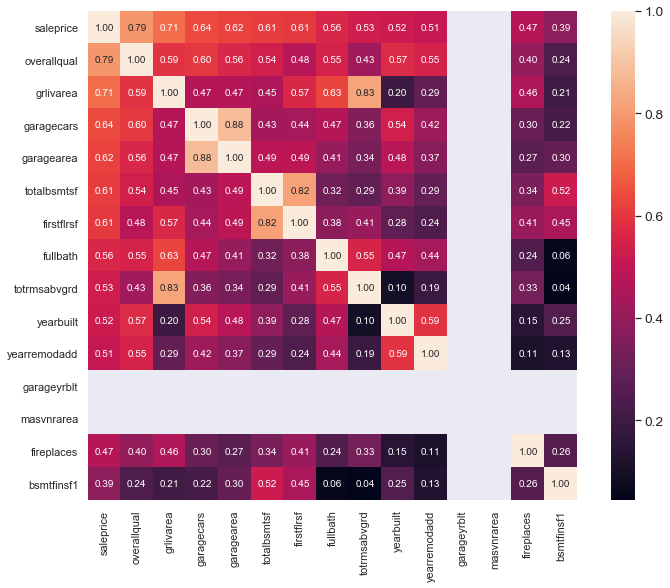

In [229]:
'''Lets look at the correlated features'''
k = 15
corrmat = df.corr()
cols = corrmat.nlargest(k, 'saleprice')['saleprice'].index
cm = np.corrcoef(df[cols].values.T)
plt.subplots(figsize=(12,9))

sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**_our target Sale price seems to be highly correlated with the feature in the heatmap above_**

**_Let's take a look at Null/NaN values in our data_**

In [230]:
missing_values = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([missing_values, percent_missing], axis = 1, keys = ['Total','percent'])[:20]
missing.head(8)

,Total,percent
lotfrontage,259,0.177397
garagefinish,81,0.055479
garagetype,81,0.055479
garagecond,81,0.055479
garagequal,81,0.055479
garageyrblt,81,0.055479
bsmtexposure,38,0.026027
bsmtfintype2,38,0.026027


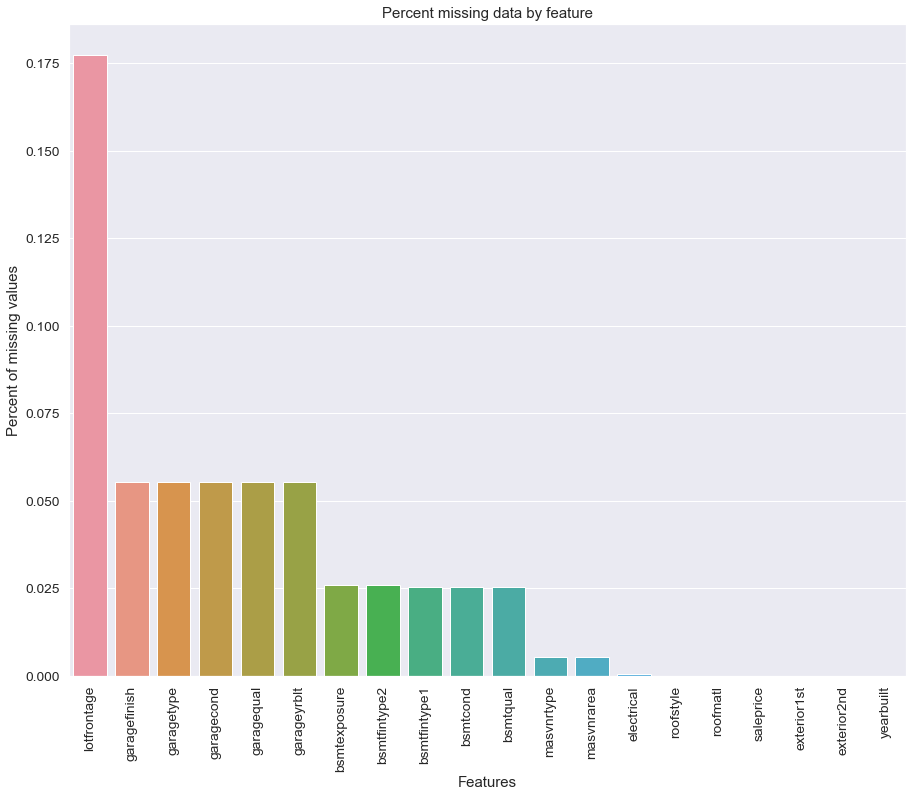

In [231]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing.index, y=missing.percent)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

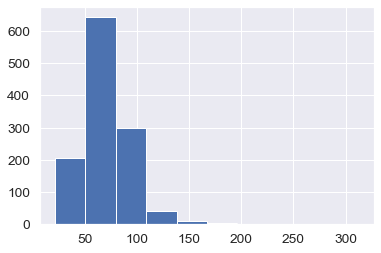

In [232]:
plt.hist(df['lotfrontage'])
plt.show()

In [233]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood 
#due to skewed disrtribution
df['lotfrontage']= df.groupby('neighborhood')['lotfrontage'].transform(lambda x: x.fillna(x.median()))

In [234]:
for col in ('garagetype' , 'garagefinish', 'garagequal', 'garagecond'):
    df[col] = df[col].fillna('None')

In [235]:
df['garageyrblt'] = df['garageyrblt'].fillna('0')

In [236]:
for col in ('bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2'):
    df[col] = df[col].fillna('None')

In [237]:
df["masvnrtype"] = df["masvnrtype"].fillna("None")
df["masvnrarea"] = df["masvnrarea"].fillna(0)

In [238]:
# fill the missing value with the most common
df['electrical']=df['electrical'].fillna(df['electrical'].mode()[0])

In [239]:
#sanity check
df.isnull().sum().sort_values(ascending = False)

saleprice        0
extercond        0
roofstyle        0
roofmatl         0
exterior1st      0
exterior2nd      0
masvnrtype       0
masvnrarea       0
exterqual        0
foundation       0
salecondition    0
bsmtqual         0
bsmtcond         0
bsmtexposure     0
bsmtfintype1     0
bsmtfinsf1       0
bsmtfintype2     0
bsmtfinsf2       0
yearremodadd     0
yearbuilt        0
overallcond      0
overallqual      0
mssubclass       0
mszoning         0
lotfrontage      0
lotarea          0
street           0
lotshape         0
landcontour      0
utilities        0
                ..
wooddecksf       0
openporchsf      0
enclosedporch    0
threessnporch    0
screenporch      0
poolarea         0
miscval          0
mosold           0
yrsold           0
saletype         0
garagefinish     0
garagetype       0
heatingqc        0
fireplaces       0
centralair       0
electrical       0
firstflrsf       0
secondflrsf      0
lowqualfinsf     0
grlivarea        0
bsmtfullbath     0
bsmthalfbath

### _Dealing with outliers_ 

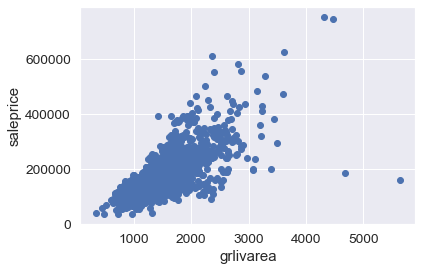

In [240]:
plt.scatter(df['grlivarea'],df['saleprice'])
plt.xlabel('grlivarea')
plt.ylabel('saleprice')
plt.show()

We have a couple of outliers that might cause our model to overfit. lets remove those points!

In [241]:
#deleting points
df = df.drop(df[df['id']== 1299].index)
df = df.drop(df[df['id']==524].index)


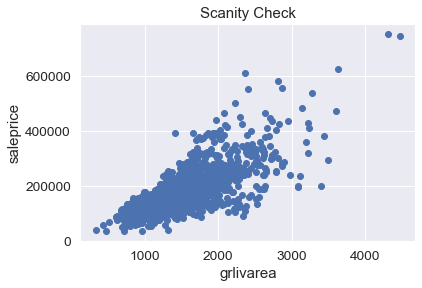

In [242]:
plt.scatter(df['grlivarea'],df['saleprice'])
plt.title('Scanity Check')
plt.xlabel('grlivarea')
plt.ylabel('saleprice')
plt.show()

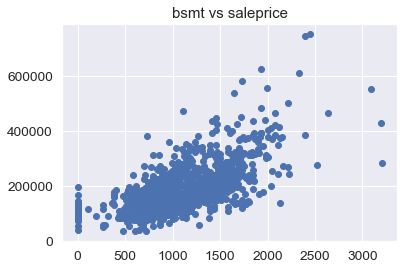

In [243]:
plt.scatter(df['totalbsmtsf'],df['saleprice'])
plt.title('bsmt vs saleprice')
plt.show()

Instead of dropping those values I combined All the Square footage into total SF feature and it did solve the oulier problem I would have otherwise

In [244]:
# Adding total sqfootage feature 
df['totalsf'] = df['totalbsmtsf'] + df['firstflrsf'] + df['secondflrsf']

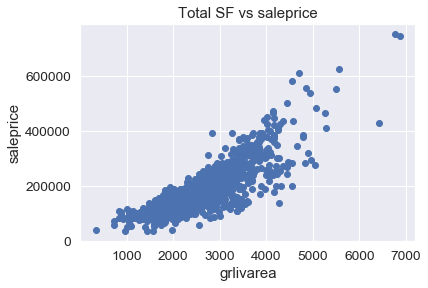

In [245]:
plt.scatter(df['totalsf'],df['saleprice'])
plt.title('Total SF vs saleprice')
plt.xlabel('grlivarea')
plt.ylabel('saleprice')
plt.show()

In [246]:
df['saleprice'].describe()

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

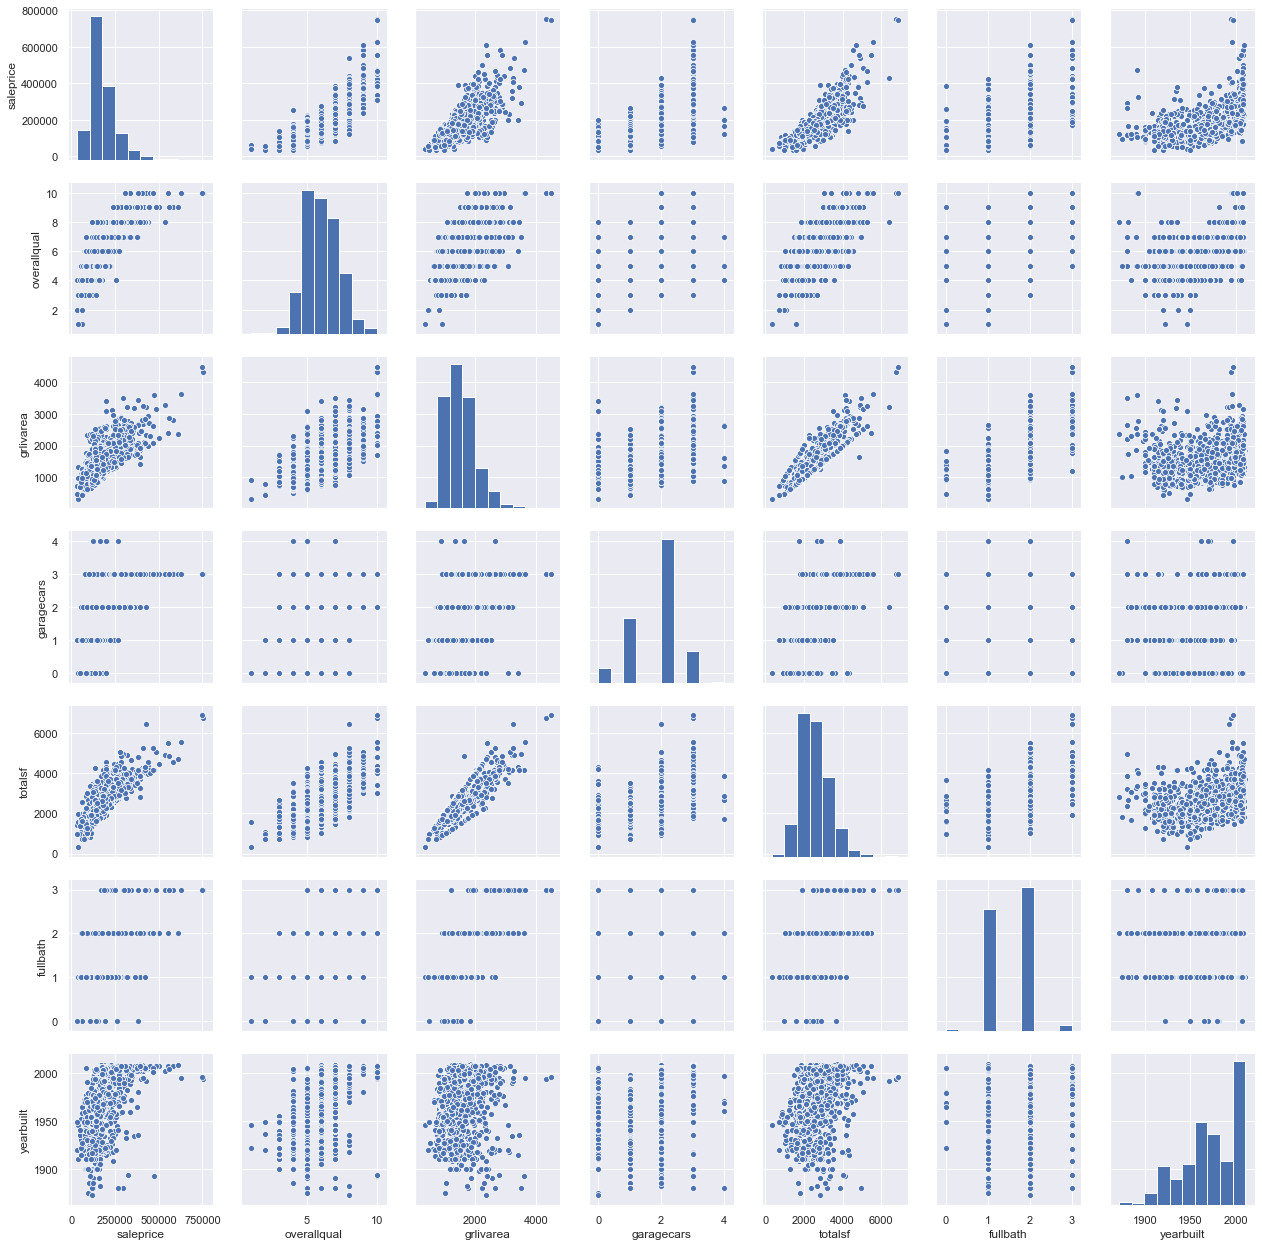

In [247]:
#scatterplot
sns.set()
cols = ['saleprice', 'overallqual', 'grlivarea', 'garagecars', 'totalsf', 'fullbath', 'yearbuilt']
sns.pairplot(df[cols], size = 2.5)
plt.show()

## Normalizing the variables

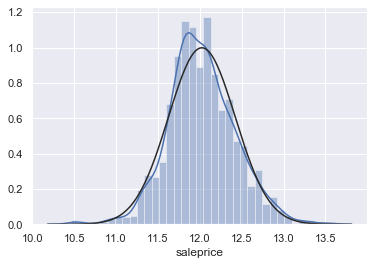

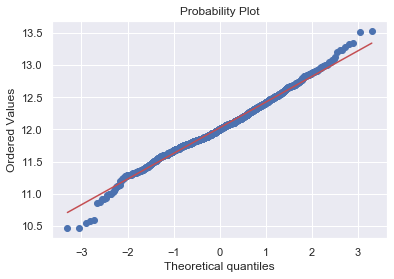

In [248]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

#use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["saleprice"] = np.log1p(df["saleprice"])

#Check the new distribution 
sns.distplot(df['saleprice'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df['saleprice'], plot=plt)
plt.show()


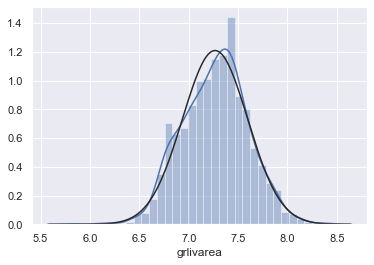

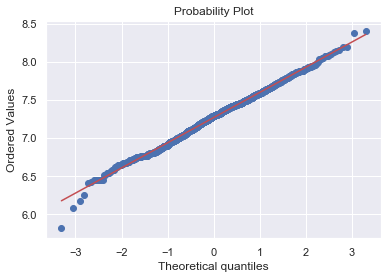

In [249]:
#use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["grlivarea"] = np.log1p(df["grlivarea"])

#Check the new distribution 
sns.distplot(df['grlivarea'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df['grlivarea'], plot=plt)
plt.show()

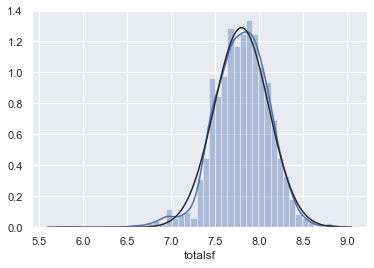

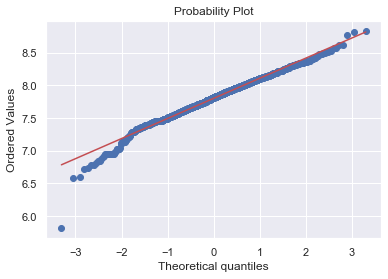

In [250]:
#use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["totalsf"] = np.log1p(df["totalsf"])

#Check the new distribution 
sns.distplot(df['totalsf'] , fit=norm);
fig = plt.figure()
res = stats.probplot(df['totalsf'], plot=plt)
plt.show()


lrm is the best fit model for this Dataset because it has a higher r and r squared values as well as lower errors of the prediction

In [251]:
rate = pd.read_csv(r'C:\\Users\Rahul Miglani\Untitled Folder\30_yr.csv')

In [252]:
rate.head()

,date,mortgage_30_yr
0,1971.0,7.541750
1,1972.0,7.383269
2,1973.0,8.044808
3,1974.0,9.187115
4,1975.0,9.047115


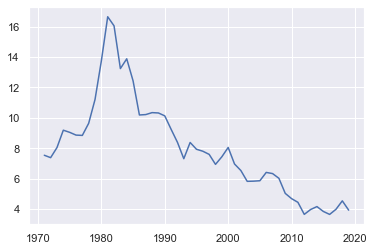

In [253]:
plt.plot(rate['date'], rate['mortgage_30_yr'])
plt.show()

In [254]:
rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
date              49 non-null float64
mortgage_30_yr    49 non-null float64
dtypes: float64(2)
memory usage: 880.0 bytes


In [255]:
df['date']= df['yrsold'].astype(int)

In [256]:
df_new = df['date']

In [257]:
df_1 = pd.merge(df_new, rate, on='date')

In [258]:
df = pd.merge(df, df_1)

In [259]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,...,poolarea,miscval,mosold,yrsold,saletype,salecondition,saleprice,totalsf,date,mortgage_30_yr
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,2,2008,WD,Normal,12.247699,7.850493,2008,6.02717
1,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,2,2008,WD,Normal,12.247699,7.850493,2008,6.02717
2,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,2,2008,WD,Normal,12.247699,7.850493,2008,6.02717
3,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,2,2008,WD,Normal,12.247699,7.850493,2008,6.02717
4,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,2,2008,WD,Normal,12.247699,7.850493,2008,6.02717


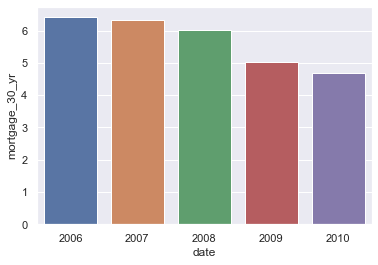

In [260]:
sns.barplot(x = df['date'],y =  df['mortgage_30_yr'])
plt.show()

In [261]:
df.corr()['saleprice']

id               -0.022290
mssubclass       -0.067557
lotfrontage       0.373857
lotarea           0.258071
overallqual       0.822198
overallcond      -0.035838
yearbuilt         0.585951
yearremodadd      0.567816
masvnrarea        0.429549
bsmtfinsf1        0.386145
bsmtfinsf2        0.011232
bsmtunfsf         0.224241
totalbsmtsf       0.645476
firstflrsf        0.619496
secondflrsf       0.321867
lowqualfinsf     -0.039052
grlivarea         0.738148
bsmtfullbath      0.239180
bsmthalfbath     -0.004051
fullbath          0.598749
halfbath          0.313397
bedroomabvgr      0.211196
kitchenabvgr     -0.144662
totrmsabvgrd      0.537680
fireplaces        0.493072
garagecars        0.681714
garagearea        0.656856
wooddecksf        0.339741
openporchsf       0.324246
enclosedporch    -0.149407
threessnporch     0.052868
screenporch       0.124051
poolarea          0.076980
miscval          -0.016681
mosold            0.059012
yrsold           -0.035858
saleprice         1.000000
t

In [264]:
# converting the yrsold to a categorical variable
df['yrsold'] = df['yrsold'].astype(str)
df['mortgage_30_yr'] = df['mortgage_30_yr'].astype(str)

In [265]:
df = pd.concat([df,pd.get_dummies(df.kitchenqual, prefix="kitchenqual")], axis=1)
df = pd.concat([df,pd.get_dummies(df.street, prefix="street")], axis=1)
df = pd.concat([df,pd.get_dummies(df.mszoning, prefix="mszoning",drop_first=True)],axis=1)
df = pd.concat([df,pd.get_dummies(df.mortgage_30_yr, prefix='mortgage_30_yr')], axis = 1)

dummy_column_names = list(pd.get_dummies(df.kitchenqual, prefix="kitchenqual").columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.street, prefix="street").columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.mszoning, prefix="mszoning",drop_first = True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df.mortgage_30_yr, prefix = 'mortgage_30_yr').columns)


In [266]:
X = df[['overallqual','totalsf','garagecars','grlivarea', 'lotfrontage']+dummy_column_names]
Y = np.log1p(df['saleprice'])

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size = 0.2, 
                                                    random_state = 465)

In [268]:
lrm = LinearRegression()

lrm.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model in training set is: 0.8629167537041056
-----Test set statistics-----
R-squared of the model in test set is: 0.8617708253833751
Mean absolute error of the prediction is: 0.008374138413396187
Mean squared error of the prediction is: 0.00013053323437383304
Root mean squared error of the prediction is: 0.011425114195220678
Mean absolute percentage error of the prediction is: 0.3270882135675697


In [269]:
# Perform 6-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lrm, X_train, y_train, cv=6)
print(scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.8628943642711558
Accuracy: 0.86 (+/- 0.00)


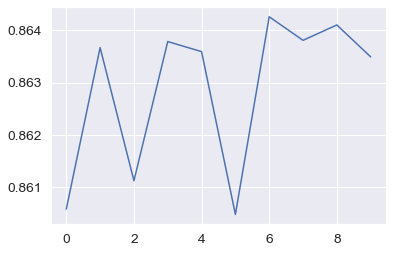

[0.86058099 0.86367048 0.8611228  0.86378635 0.86359375 0.86047829
 0.86426115 0.86380998 0.86410393 0.86349363]


In [277]:
scores = cross_val_score(lrm, X_train, y_train, cv=10)
plt.plot(scores)
plt.show()
print(scores)

In [283]:
# There is no over-fiiting in our model

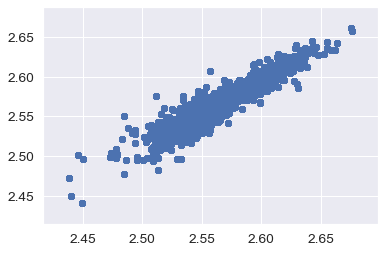

In [282]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(lrm, X_train, y_train, cv=5)
plt.scatter(y_train,y_pred)

In [279]:
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(cv =5)

ridge_cv.fit(X_train,y_train)
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.1
R-squared of the model in training set is: 0.8629169509365551
-----Test set statistics-----
R-squared of the model in test set is: 0.8617704625224288
Mean absolute error of the prediction is: 0.00873600809892985
Mean squared error of the prediction is: 0.00014559730109783508
Root mean squared error of the prediction is: 0.012066370668010952
Mean absolute percentage error of the prediction is: 0.3412411499692622


In [284]:
# Perform 6-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(ridge_cv, X_train, y_train, cv=6)
print(scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.8628938308110431
Accuracy: 0.86 (+/- 0.00)


In [280]:
lasso_cv = LassoCV(cv=5)

lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0002444242480203853
R-squared of the model in training set is: 0.8466763095744174
-----Test set statistics-----
R-squared of the model in test set is: 0.845818615820674
Mean absolute error of the prediction is: 0.00873600809892985
Mean squared error of the prediction is: 0.00014559730109783508
Root mean squared error of the prediction is: 0.012066370668010952
Mean absolute percentage error of the prediction is: 0.3412411499692622


In [285]:
# Perform 6-fold cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lasso_cv, X_train, y_train, cv=6)
print(scores.mean())
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.8466580141374208
Accuracy: 0.85 (+/- 0.00)


In [281]:
elasticnet_cv = ElasticNetCV(cv=5)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0004888484960407707
R-squared of the model in training set is: 0.8466241300656511
-----Test set statistics-----
R-squared of the model in test set is: 0.845760299700652
Mean absolute error of the prediction is: 0.008738085144034237
Mean squared error of the prediction is: 0.00014565237045481946
Root mean squared error of the prediction is: 0.012068652387686849
Mean absolute percentage error of the prediction is: 0.34132060163282185


### _Lrm and Ridge_cv are the best models because of their High R-squared and accuracy_